We will be building a model that will complete a sentence based on a word or a few characters passed into it

The model will be fed with a word and will predict what the next character in the sentence will be. This process will repeat itself until we generate a sentence of our desired length.

In [1]:
import torch
from torch import nn
import numpy as np

In [97]:
# create all sentences i want to predict
text = ["hello", "how are you"]
# text = ['hey how are you','good i am fine','have a nice day']

# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))
# print(int2char)

# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}
# print(char2int)


# Finding the length of the longest string in our data
maxlen = len(max(text, key=len))

# Padding

# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of
# the sentence matches the length of the longest sentence
for i in range(len(text)):
  while len(text[i])<maxlen:
      text[i] += ' '
        
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
  input_seq.append(text[i][:-1])
    
    # Remove first character for target sequence
  target_seq.append(text[i][1:])
  print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))
    
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]
    
# print(input_seq)

dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

# Input shape --> (Batch Size, Sequence Length, One-Hot Encoding Size)
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)

print(input_seq.shape)
print(input_seq)

Input Sequence: hello     
Target Sequence: ello      
Input Sequence: how are yo
Target Sequence: ow are you
(2, 10, 10)
[[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]]


In [87]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)

In [88]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [89]:
# Instantiate the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
# model.to("cpu")

# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [90]:
# Training Run
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
#     input_seq.to(device)
    output, hidden = model(input_seq)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100............. Loss: 0.7788
Epoch: 20/100............. Loss: 0.2903
Epoch: 30/100............. Loss: 0.0884
Epoch: 40/100............. Loss: 0.0368
Epoch: 50/100............. Loss: 0.0206
Epoch: 60/100............. Loss: 0.0141
Epoch: 70/100............. Loss: 0.0109
Epoch: 80/100............. Loss: 0.0090
Epoch: 90/100............. Loss: 0.0076
Epoch: 100/100............. Loss: 0.0067


In [91]:
# This function takes in the model and character as arguments and returns the next character prediction and hidden state
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
#     character.to(device)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden

In [92]:
# This function takes the desired output length and input characters as arguments, returning the produced sentence
def sample(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [94]:
sample(model, 15, 'hello')

'helloollooolooo'

# RNN with sinus function

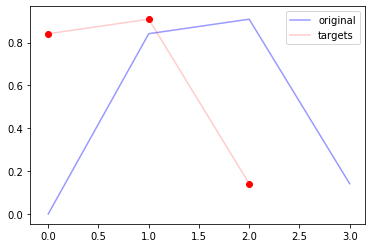

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

x_ = np.arange(0, 4)
# print(x)

inputs = x_[:-1]
# print(data)

y = np.sin(x_)
# print(y)

targets = y[1:]
# print(targets)

fig, ax = plt.subplots()
# ax.scatter(x, y, color = "blue", label = "target", alpha = 0.5)
ax.plot(x_, y, color = "blue", alpha = 0.4, label = "original")
ax.plot(inputs, targets, label ="targets", color = "red", alpha = 0.2)
ax.scatter(inputs, targets, color = "red")
# ax.plot(data, targets, color = "red")
ax.legend()

In [18]:
# transform to tensor
inputs = torch.Tensor(inputs)
targets = torch.Tensor(targets)

In [42]:
# hyper parameters of model
input_size = 1
hidden_size = 1
batch_size = 1 
sequence_length = 1
output_size = 1
n_layers = 1

In [74]:
# define model
# create model
class RNN(torch.nn.Module):
    
    def __init__(self):
        
        super(RNN, self).__init__()
        
#         self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
    
                         
    def forward(self, hidden, x):
        
        # reshape input
        x = x.view(batch_size, sequence_length, input_size)
        
#         print("x input: ", x.shape)
        
        # forward
        out, hidden =  self.rnn(x, hidden)
        
#         print("output shape: ", out.view(-1, output_size).shape)
        return hidden, out.view(-1, output_size)

    def init_hidden(self):
        
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
#         return Variable(torch.zeros(1, batch_size, hidden_size))
        return (torch.zeros(1, batch_size, hidden_size))
#         return (torch.zeros(batch_size, hidden_size).unsqueeze(0))

In [70]:
torch.zeros(1, batch_size, hidden_size)

tensor([[[0.]]])

In [71]:
model = RNN()

criterion = torch.nn.MSELoss()  # this is for regression mean squared loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [72]:
# training

# iterate by epochs
for epoch in range(1000):
    
    loss = 0

    optimizer.zero_grad()

    # hidden state to zero (nothing before)
    hidden = model.init_hidden()

    # present each input
    for input_, label in zip(inputs, targets):
    
#         print("hidden shape: ", hidden.shape)
#         print("input shape: ", input_.shape)
        
        # forward with input
        hidden, output = model(hidden, input_) 

        # loss 
        loss += criterion(output, label)

    # backpropagation
    loss.backward()

    # update parameters
    optimizer.step()
    
    print("epoch: ", epoch, " - loss: " + str(loss.item()))

RuntimeError: Expected hidden[0] size (1, 1, 1), got (1, 1)

In [73]:
# do predictions
hidden = model.init_hidden()

predictions = []

# print(len(x_))
for x in range(len(x_)):
    
    hidden, outputs = model.forward(hidden, torch.Tensor([x]).squeeze())
    
#     print(outputs.item())
    predictions.append(outputs.item())

RuntimeError: Expected hidden[0] size (1, 1, 1), got (1, 1)

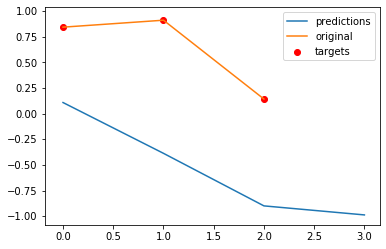

In [16]:
# plot predicionts
fig, ax = plt.subplots()
# print(x_)
ax.plot(x_, predictions, label = "predictions")
ax.plot(x_[1:]-1, y[1:], label = "original")
ax.scatter(x_[:-1], y[1:], label = "targets", color = "red")

ax.legend()

# RNN with hello 

In [120]:
import torch
import torch.nn as nn
from torch.autograd import Variable

# unique characters
idx2char = ['h', 'e', 'l', 'o', 'o', 'o']
# h: 0
# e: 1
# l: 2
# o: 3

# hell
x_data = [0, 1, 2, 2];

# length 4 because there is 4 differents characters
one_hot_look = [
    [1, 0, 0, 0], # h
    [0, 1, 0, 0], # e
    [0, 0, 1, 0], # l
    [0, 0, 0, 1], # o
]

# print(one_hot_look[3])

# ello 
# (because text is like a time serie and I want to predict the nex character, so the target will be the next character of each char in x_data)
y_data = [1, 2, 2, 3]

# transform x-data to one-hot encoding
x_one_hot = [ one_hot_look[x] for x in x_data]
# y_one_hot = [ one_hot_look[x] for x in y_data]

# print(y_one_hot)
# data to tensor
inputs = Variable(torch.Tensor(x_one_hot))
targets = Variable(torch.LongTensor(y_data))

input_size = len(one_hot_look[0])
hidden_size = input_size
batch_size = 1
sequence_length = 4
num_classes = input_size
num_layers = 1

# create model
class RNN(torch.nn.Module):
    
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
                         
    def forward(self, hidden, x):
        
#         print(x.shape)
        
        # reshape input
        x = x.view(batch_size, sequence_length, input_size)
        
#         print("input to RNN shape: ", x.shape)
        
        # forward
        out, hidden =  self.rnn(x, hidden)
        
        return hidden, out.view(-1, num_classes)

    def init_hidden(self):
        
        # Initialize hidden and cell states
        # (num_layers * num_directions, batch, hidden_size)
        return Variable(torch.zeros(num_layers, batch_size, hidden_size))

# instantiate model
model = RNN()

# define loss
criterion = nn.CrossEntropyLoss()
# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [121]:
# training


# train by epochs
for epoch in range(0, 1000):
    
    optimizer.zero_grad()
    
    loss = 0
    hidden = model.init_hidden()
    
    # train feeding a sequence
    hidden, output = model(hidden, inputs)
    loss += criterion(output, targets)
    loss.backward()
    optimizer.step()
    print("epoch: ", epoch, " | loss: ", loss.item())
    # finish train feeding a sequence
    
    # feed one char by one char
    
#     for input_, label in zip(inputs, targets):
        
# #         print(input_.shape)
#     #     print(label.unsqueeze(0).shape)
#         # evaluate model
#         hidden, output = model(hidden, input_)
#         # get predictions
#         val, idx = output.max(1)
#         loss += criterion(output, label.unsqueeze(0))
# #         print(idx2char[idx], "label: ", idx2char[label])
    
#     print("epoch: ", epoch, " | loss: ", loss.item())
#     loss.backward()
#     optimizer.step()

epoch:  0  | loss:  1.5757358074188232
epoch:  1  | loss:  1.3357949256896973
epoch:  2  | loss:  1.1334294080734253
epoch:  3  | loss:  0.9961792230606079
epoch:  4  | loss:  0.9124128818511963
epoch:  5  | loss:  0.8545787334442139
epoch:  6  | loss:  0.8063748478889465
epoch:  7  | loss:  0.7623152732849121
epoch:  8  | loss:  0.723191499710083
epoch:  9  | loss:  0.6885234117507935
epoch:  10  | loss:  0.6555707454681396
epoch:  11  | loss:  0.6261085867881775
epoch:  12  | loss:  0.6030715703964233
epoch:  13  | loss:  0.5893162488937378
epoch:  14  | loss:  0.5797090530395508
epoch:  15  | loss:  0.5693175792694092
epoch:  16  | loss:  0.5605154633522034
epoch:  17  | loss:  0.5522721409797668
epoch:  18  | loss:  0.5439419150352478
epoch:  19  | loss:  0.5368401408195496
epoch:  20  | loss:  0.5318097472190857
epoch:  21  | loss:  0.5271846652030945
epoch:  22  | loss:  0.5231980085372925
epoch:  23  | loss:  0.5205021500587463
epoch:  24  | loss:  0.5178208351135254
epoch:  25 

epoch:  341  | loss:  0.4738820791244507
epoch:  342  | loss:  0.4738633334636688
epoch:  343  | loss:  0.4738445580005646
epoch:  344  | loss:  0.4738258123397827
epoch:  345  | loss:  0.4738072156906128
epoch:  346  | loss:  0.47378861904144287
epoch:  347  | loss:  0.4737701714038849
epoch:  348  | loss:  0.4737517833709717
epoch:  349  | loss:  0.47373348474502563
epoch:  350  | loss:  0.4737151861190796
epoch:  351  | loss:  0.4736969769001007
epoch:  352  | loss:  0.4736787974834442
epoch:  353  | loss:  0.47366076707839966
epoch:  354  | loss:  0.4736426770687103
epoch:  355  | loss:  0.4736247658729553
epoch:  356  | loss:  0.47360682487487793
epoch:  357  | loss:  0.4735890030860901
epoch:  358  | loss:  0.47357118129730225
epoch:  359  | loss:  0.47355347871780396
epoch:  360  | loss:  0.47353577613830566
epoch:  361  | loss:  0.4735181927680969
epoch:  362  | loss:  0.47350066900253296
epoch:  363  | loss:  0.473483145236969
epoch:  364  | loss:  0.4734656810760498
epoch:  3

epoch:  686  | loss:  0.3547024428844452
epoch:  687  | loss:  0.3546876311302185
epoch:  688  | loss:  0.35467293858528137
epoch:  689  | loss:  0.35465824604034424
epoch:  690  | loss:  0.35464370250701904
epoch:  691  | loss:  0.3546292185783386
epoch:  692  | loss:  0.35461491346359253
epoch:  693  | loss:  0.3546005189418793
epoch:  694  | loss:  0.3545863628387451
epoch:  695  | loss:  0.3545721769332886
epoch:  696  | loss:  0.3545581102371216
epoch:  697  | loss:  0.35454416275024414
epoch:  698  | loss:  0.3545302152633667
epoch:  699  | loss:  0.3545163869857788
epoch:  700  | loss:  0.35450270771980286
epoch:  701  | loss:  0.3544890284538269
epoch:  702  | loss:  0.3544754087924957
epoch:  703  | loss:  0.3544619083404541
epoch:  704  | loss:  0.35444849729537964
epoch:  705  | loss:  0.3544350862503052
epoch:  706  | loss:  0.35442182421684265
epoch:  707  | loss:  0.3544086217880249
epoch:  708  | loss:  0.35439544916152954
epoch:  709  | loss:  0.3543824255466461
epoch: 

In [122]:
# parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

rnn.weight_ih_l0 tensor([[-1.7786, -2.3806, -1.4605, -0.1670],
        [ 3.3692, -3.8771, -1.7714,  0.2418],
        [-3.7073,  2.4700, -1.3504,  0.2012],
        [-4.2258, -1.2781,  1.4582, -0.4340]])
rnn.weight_hh_l0 tensor([[  1.4087,   0.4948,   0.0374,  -0.7896],
        [  2.8944,   0.6467,  -0.6588,   0.0979],
        [  0.3689,   1.9626,  -2.6739, -14.6571],
        [ -1.1021,  -4.3824,   2.6738,  10.6441]])
rnn.bias_ih_l0 tensor([-1.5459,  0.3350, -2.4582, -0.0663])
rnn.bias_hh_l0 tensor([-1.4088,  0.8661, -3.0453,  0.3004])


In [123]:
# idx2char = ['h', 'e', 'l', 'o']
# h: 0
# e: 1
# l: 2
# o: 3

# evaluate model
# print(torch.Tensor(one_hot_look[0]))
# print(model.init_hidden())
letters = [1, 2, 2, 3]
hidden, output = model(model.init_hidden(), torch.Tensor([ one_hot_look[x] for x in letters]))

print(output.shape)

print("Input: \n")
for i in range(4):
    print(idx2char[letters[i]])

print("\nPrediction")
for i in range(4):
    print(idx2char[output[i].argmax()])

torch.Size([4, 4])
Input: 

e
l
l
o

Prediction
o
l
l
o
